In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import cv2
import skimage
from imageio import imread
import csv
import math

# Creating a generator to load and preprocess the images

In [2]:
csv_path = "/home/houcem/data/data.csv"
sample_size = sum(1 for row in open(csv_path))

In [3]:
batch_size = 32

In [4]:
def generator(csv_path, batch_size):
    X_train = []
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, reverse, brake, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle, reverse, brake])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                y_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    y_train = np.asarray(y_train)
                    yield(X_train, y_train)
                    X_train = []
                    y_train = []
                    batchcount = 0

# Defining the model

In [5]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
#tf.config.experimental_run_functions_eagerly(True)
#tf.compat.v1.disable_eager_execution()

In [6]:
from keras.layers import Lambda, Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D
from keras.activations import relu, linear
from keras import Model
from keras.callbacks import Callback, ReduceLROnPlateau,EarlyStopping
from keras import backend as K
from keras.losses import binary_crossentropy

In [38]:
# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return(mu + K.exp(sigma / 2) * eps)

In [39]:
image_input = Input(shape=(112,112,1))
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(image_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(x)
x = Flatten()(x)

z = Dense(49, activation ='relu')(x)

encoder = Model(inputs= [image_input], outputs = [z])

encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 112, 112, 1)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 128)     1280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 56, 56, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0   

In [40]:
input_decoder = Input(shape=(49,))

d = Dense(392, activation = 'relu')(input_decoder)
d = Reshape((7,7,8))(d)
d = Conv2D(8,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(16,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(32,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(64,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(128,(3, 3), strides=1, activation='relu', padding='same')(d)
decoded = Conv2D(1, (3, 3), strides = 1, activation='relu', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [41]:
Decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 392)               19600     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 28, 16)        0   

# Implementing the vae loss

In [42]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * 1000
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# Creating the autoencoder

In [43]:
img_input = Input(shape=(112, 112, 1))
Encoded = encoder([img_input])
Decoded = Decoder(Encoded)

autoencoder = Model(inputs = [img_input], outputs = Decoded)

In [44]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 112, 112, 1)]     0         
_________________________________________________________________
model_3 (Model)              (None, 49)                118577    
_________________________________________________________________
model_4 (Model)              (None, 112, 112, 1)       119497    
Total params: 238,074
Trainable params: 238,074
Non-trainable params: 0
_________________________________________________________________


In [45]:
early_stopping = EarlyStopping(monitor= 'loss', patience = 8)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.001, min_lr=10e-20, patience = 5, min_delta=0.001)

In [50]:
autoencoder.compile(loss = 'mse', optimizer= keras.optimizers.RMSprop(learning_rate=0.0001)) #previous learning rate is 10e-4

# Loading the Mnist dataset from keras

In [1]:
from keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [53]:
class DataGenerator(tf.compat.v2.keras.utils.Sequence):
 
    def __init__(self, X_data, batch_size, dim,
                 to_fit, shuffle = True):        
        self.batch_size = batch_size
        self.X_data = X_data
        self.to_fit = to_fit
        self.dim = dim
        self.shuffle = shuffle
        self.n = 0
        self.list_IDs = np.arange(len(self.X_data))
        self.on_epoch_end()    
    
    def __next__(self):
        # Get one batch of data
        data = self.__getitem__(self.n)
        # Batch index
        self.n += 1
        
        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end
            self.n = 0
        
        return data    
    
    def __len__(self):
        # Return the number of batches of the dataset
        return math.ceil(len(self.indexes)/self.batch_size)    
    
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:
            (index+1)*self.batch_size]        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X = self._generate_x(list_IDs_temp)
        
        if self.to_fit:
            return X, X
        else:
            return X    
        
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.X_data))
        
        if self.shuffle: 
            np.random.shuffle(self.indexes)    
            
    def _generate_x(self, list_IDs_temp):
               
        X = np.empty((self.batch_size, *self.dim))
        
        for i, ID in enumerate(list_IDs_temp):
            
            X[i,] = (cv2.resize(self.X_data[ID], (112,112), interpolation = cv2.INTER_AREA))
            
            # Normalize data
            X = (X/255).astype('float32')
            
        return X[:,:,:, np.newaxis]   

In [54]:
train_generator = DataGenerator(x_train, batch_size = batch_size,
                                dim = (112,112), 
                                to_fit=True, shuffle=False)

In [55]:
autoencoder.fit(train_generator, steps_per_epoch = sample_size/batch_size, epochs = 20)

/home/houcem/miniconda3/envs/carla/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


Epoch 1/20
1563/1562 [==============================] - 195s 125ms/step - loss: 0.0017
Epoch 2/20
1563/1562 [==============================] - 195s 125ms/step - loss: 0.0012
Epoch 3/20
1563/1562 [==============================] - 194s 124ms/step - loss: 9.6837e-04
Epoch 4/20
1563/1562 [==============================] - 192s 123ms/step - loss: 8.3973e-04
Epoch 5/20
1563/1562 [==============================] - 194s 124ms/step - loss: 7.6787e-04
Epoch 6/20
1563/1562 [==============================] - 192s 123ms/step - loss: 6.9687e-04
Epoch 7/20
1563/1562 [==============================] - 189s 121ms/step - loss: 6.5492e-04
Epoch 8/20
1563/1562 [==============================] - 189s 121ms/step - loss: 6.1678e-04
Epoch 9/20
1563/1562 [==============================] - 190s 122ms/step - loss: 5.8379e-04
Epoch 10/20
1563/1562 [==============================] - 194s 124ms/step - loss: 5.5850e-04
Epoch 11/20
1563/1562 [==============================] - 197s 126ms/step - loss: 5.2933e-04
Epoch

In [56]:
autoencoder.save_weights("autoencoder_mnist.h5")

# Let's check out the prediction for the first image

In [3]:
test_image = x_test[0]/255.0

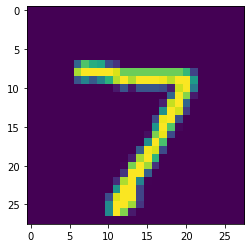

In [5]:
import matplotlib.pyplot as plt

plt.imshow(test_image)

In [58]:
test_image = (cv2.resize(test_image, (112,112), interpolation = cv2.INTER_AREA))

In [61]:
test_image = test_image.reshape((1,112,112,1))

In [62]:
prediction = autoencoder.predict(test_image)

In [63]:
prediction = prediction.reshape(112,112,1)

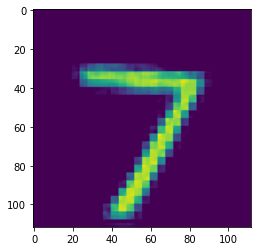

In [64]:
plt.imshow(prediction)